In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import seaborn as sns
plt.style.use('fivethirtyeight')
from matplotlib.pylab import rcParams
from sklearn.feature_selection import VarianceThreshold
rcParams['figure.figsize'] = 12,4

In [11]:
df=pd.read_csv("./archive/stocks/AAPL.csv", parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [60]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
9904,2020-03-26,246.520004,258.679993,246.360001,258.440002,258.440002,63021800
9905,2020-03-27,252.750000,255.869995,247.050003,247.740005,247.740005,51054200
9906,2020-03-30,250.740005,255.520004,249.399994,254.809998,254.809998,41994100
9907,2020-03-31,255.600006,262.489990,252.000000,254.289993,254.289993,49250500
9908,2020-04-01,246.500000,248.720001,239.130005,240.910004,240.910004,43956200


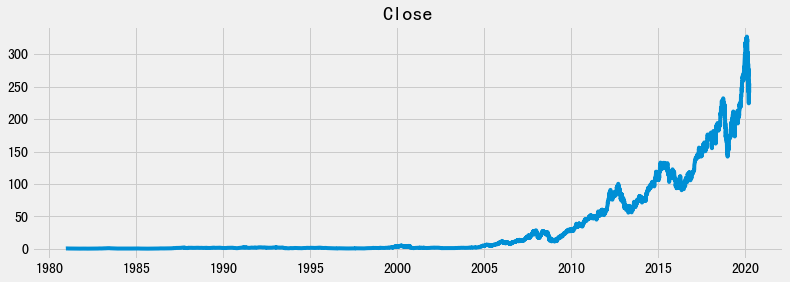

In [12]:
plt.plot(df['Date'], df['Close'])
plt.title("Close")
plt.show()

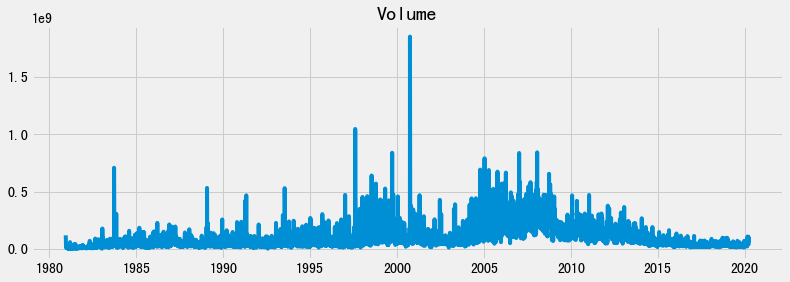

In [14]:
plt.plot(df['Date'], df['Volume'])
plt.title("Volume")
plt.show()

In [15]:
# select data
df1=df.drop(['Date'], axis=1)
df1.head()

,Open,High,Low,Close,Adj Close,Volume
0,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [65]:

from scipy import stats
 
"""
kstest method: KS test, the parameters are: data to be tested, test method (here set to norm normal distribution), mean and standard deviation
The results return two values: statistic → D-value, pvalue → P-value
The p-value is greater than 0.05, and the distribution is normal
H0:sample meets  
H1:sample does not fit 
If p>0.05 accept H0 ,and vice versa 
"""

for c in df1.columns:
    
    u = df1[c].mean()  
    std = df1[c].std()  
    print(c,'==>',stats.kstest(df1[c], 'norm', (u, std)))

Open ==> KstestResult(statistic=0.3062013491999453, pvalue=0.0)
High ==> KstestResult(statistic=0.3052459994302136, pvalue=0.0)
Low ==> KstestResult(statistic=0.30732137745572274, pvalue=0.0)
Close ==> KstestResult(statistic=0.30580800351324655, pvalue=0.0)
Adj Close ==> KstestResult(statistic=0.30801779592501877, pvalue=0.0)
Volume ==> KstestResult(statistic=0.16878439167321624, pvalue=3.073559071995015e-247)


In [17]:
# Data pre-processing - replacement of abnormal data
df1=df1.replace("None",0).astype(float)

X, y = df1.drop(['Close'], axis=1), df1['Close']
# Data pre-processing - normalization
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler_X=scaler.fit(X)
X=pd.DataFrame(scaler_X.transform(X), columns=X.columns)

scaler=MinMaxScaler()
scaler_y=scaler.fit(np.array(y).reshape(-1,1))
y=scaler_y.transform(np.array(y).reshape(-1,1))
X.head()

,Open,High,Low,Adj Close,Volume
0,0.000970,0.000967,0.000981,0.000768,0.063023
1,0.000894,0.000886,0.000898,0.000703,0.023516
2,0.000784,0.000777,0.000787,0.000616,0.014061
3,0.000812,0.000811,0.000822,0.000644,0.011462
4,0.000853,0.000852,0.000863,0.000676,0.009711


In [18]:
data1=X.copy()
data2=X.drop(['Adj Close'], axis=1)

In [19]:
from sklearn.model_selection import train_test_split
# X=pd.DataFrame(poly_X).copy()
def split_data(X,y1):
    train_ratio=0.7 # The first 70% of the data is training, 30% of the data is testing
    length=int(train_ratio*X.shape[0])
    X_train, X_test, y_train, y_test = X.iloc[:length,:],X.iloc[length:,:], y1[:length],y1[length:]
    # X_train, X_test, y_train, y_test = train_test_split(X,y1,test_size=0.3)
    train_x = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
    test_x = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))
    print('train_x.shape, train_y.shape, test_x.shape, test_y.shape')
    print(train_x.shape, y_train.shape, test_x.shape, y_test.shape)
    return train_x, test_x, y_train, y_test

In [20]:
# buliding model
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
def base_model(train_x,train_y,bias=1, units=2):
    model=Sequential()
    model.add(Input(shape=(train_x.shape[1], train_x.shape[2])))
    # Two neurons
    model.add(LSTM(units,unit_forget_bias=bias))
    # Output layer
    # Fully connected layer with only one neuron
    model.add(Dense(train_y.shape[1]))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics='mape')
    return model

In [21]:
from tensorflow.keras.utils import plot_model
# Data1's model
data1_train_x,data1_test_x, data1_train_y,data1_test_y=split_data(data1,y)
model_1=base_model(data1_train_x, data1_train_y)
model_1.summary()

train_x.shape, train_y.shape, test_x.shape, test_y.shape
(6936, 1, 5) (6936, 1) (2973, 1, 5) (2973, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2)                 64        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


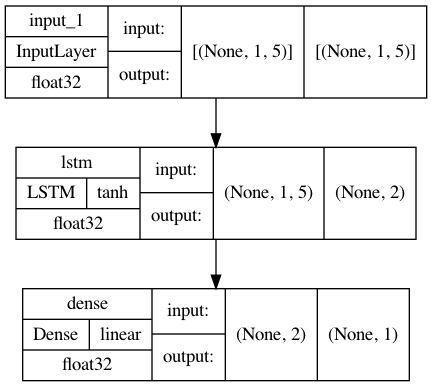

In [22]:
plot_model(model_1,to_file='model1.png', show_dtype=True, show_shapes=True, show_layer_activations=True, show_layer_names=True)

In [23]:
# Data2's model
data2_train_x,data2_test_x, data2_train_y,data2_test_y=split_data(data2,y)
model_2=base_model(data2_train_x, data2_train_y)
model_2.summary()


train_x.shape, train_y.shape, test_x.shape, test_y.shape
(6936, 1, 4) (6936, 1) (2973, 1, 4) (2973, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 2)                 56        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________


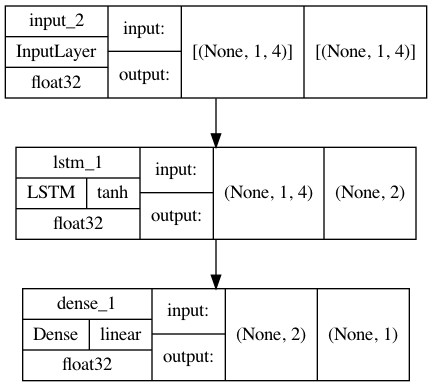

In [24]:
plot_model(model_2,to_file='model2.png', show_dtype=True, show_shapes=True, show_layer_activations=True, show_layer_names=True)


In [25]:
import numpy as np
def mape(true, pred): # mape
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / (true+1))
# mape(data2_test_y.flatten(), pred_2.flatten())

## Predictive analysis of different epochs

In [26]:
# data1 training
from sklearn.metrics import mean_absolute_percentage_error
data1_mapes=[]
epochs=[10,50,100,200]
for e in epochs:
    model_1=base_model(data1_train_x, data1_train_y)
    history = model_1.fit(data1_train_x, data1_train_y,
                    epochs=e, batch_size=4, validation_split=0.25, verbose=1)
    pred_1=model_1.predict(data1_test_x)
    mape1=mape(data1_test_y.flatten(), pred_1.flatten())
    data1_mapes.append(mape1)

Epoch 1/10
1301/1301 [==============================] - 5s 2ms/step - loss: 3.2672e-06 - mape: 730.2117 - val_loss: 7.6758e-07 - val_mape: 3.2917
Epoch 2/10
1301/1301 [==============================] - 2s 2ms/step - loss: 4.9506e-08 - mape: 24.8496 - val_loss: 3.5196e-06 - val_mape: 3.0665
Epoch 3/10
1301/1301 [==============================] - 3s 2ms/step - loss: 5.0301e-08 - mape: 22.3380 - val_loss: 1.4084e-06 - val_mape: 2.2278
Epoch 4/10
1301/1301 [==============================] - 3s 2ms/step - loss: 7.1282e-08 - mape: 16.2798 - val_loss: 6.7998e-07 - val_mape: 3.6890
Epoch 5/10
1301/1301 [==============================] - 3s 2ms/step - loss: 5.0202e-08 - mape: 97.8174 - val_loss: 2.9538e-06 - val_mape: 2.7829
Epoch 6/10
1301/1301 [==============================] - 3s 2ms/step - loss: 4.7510e-08 - mape: 12.5538 - val_loss: 3.5274e-06 - val_mape: 9.1766
Epoch 7/10
1301/1301 [==============================] - 3s 2ms/step - loss: 3.8130e-08 - mape: 33.2078 - val_loss: 3.7948e-06 - v

Epoch 53/100
1301/1301 [==============================] - 2s 2ms/step - loss: 1.7584e-08 - mape: 32.3214 - val_loss: 6.7125e-07 - val_mape: 1.6471
Epoch 54/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.0939e-08 - mape: 17.9044 - val_loss: 5.2213e-07 - val_mape: 2.8968
Epoch 55/100
1301/1301 [==============================] - 2s 2ms/step - loss: 1.4869e-08 - mape: 20.0632 - val_loss: 6.7051e-07 - val_mape: 1.5392
Epoch 56/100
1301/1301 [==============================] - 2s 2ms/step - loss: 1.7261e-08 - mape: 29.1225 - val_loss: 4.4261e-07 - val_mape: 1.1147
Epoch 57/100
1301/1301 [==============================] - 2s 2ms/step - loss: 1.5784e-08 - mape: 31.6777 - val_loss: 6.2468e-07 - val_mape: 2.1993
Epoch 58/100
1301/1301 [==============================] - 3s 2ms/step - loss: 1.6820e-08 - mape: 10.0191 - val_loss: 3.5046e-07 - val_mape: 1.2598
Epoch 59/100
1301/1301 [==============================] - 3s 2ms/step - loss: 1.6120e-08 - mape: 20.1372 - val_loss: 4

Epoch 9/200
1301/1301 [==============================] - 3s 2ms/step - loss: 3.8666e-08 - mape: 14.4652 - val_loss: 7.3574e-06 - val_mape: 4.8917
Epoch 10/200
1301/1301 [==============================] - 3s 2ms/step - loss: 2.9081e-08 - mape: 39.0246 - val_loss: 5.5471e-06 - val_mape: 5.9757
Epoch 11/200
1301/1301 [==============================] - 2s 2ms/step - loss: 3.5616e-08 - mape: 29.8631 - val_loss: 6.2315e-06 - val_mape: 4.3195
Epoch 12/200
1301/1301 [==============================] - 2s 2ms/step - loss: 2.8522e-08 - mape: 20.9032 - val_loss: 6.8210e-06 - val_mape: 3.3650
Epoch 13/200
1301/1301 [==============================] - 3s 2ms/step - loss: 2.6203e-08 - mape: 8.5980 - val_loss: 5.7462e-06 - val_mape: 3.0823
Epoch 14/200
1301/1301 [==============================] - 3s 2ms/step - loss: 2.4565e-08 - mape: 13.7611 - val_loss: 5.9070e-06 - val_mape: 3.9956
Epoch 15/200
1301/1301 [==============================] - 2s 2ms/step - loss: 2.5236e-08 - mape: 36.4206 - val_loss: 5.0

Epoch 65/200
1301/1301 [==============================] - 2s 2ms/step - loss: 1.9120e-08 - mape: 19.2299 - val_loss: 1.9330e-06 - val_mape: 1.6007
Epoch 66/200
1301/1301 [==============================] - 2s 2ms/step - loss: 1.8744e-08 - mape: 7.7915 - val_loss: 1.7792e-06 - val_mape: 1.5786
Epoch 67/200
1301/1301 [==============================] - 2s 2ms/step - loss: 1.7372e-08 - mape: 8.3179 - val_loss: 2.1514e-06 - val_mape: 2.3157
Epoch 68/200
1301/1301 [==============================] - 2s 2ms/step - loss: 1.8770e-08 - mape: 32.2605 - val_loss: 1.8592e-06 - val_mape: 2.1386
Epoch 69/200
1301/1301 [==============================] - 3s 2ms/step - loss: 1.8385e-08 - mape: 8.6725 - val_loss: 2.3223e-06 - val_mape: 3.2301
Epoch 70/200
1301/1301 [==============================] - 2s 2ms/step - loss: 2.1928e-08 - mape: 15.6377 - val_loss: 2.2928e-06 - val_mape: 2.2972
Epoch 71/200
1301/1301 [==============================] - 3s 2ms/step - loss: 1.6873e-08 - mape: 31.7471 - val_loss: 2.18

1301/1301 [==============================] - 2s 2ms/step - loss: 1.5336e-08 - mape: 23.5566 - val_loss: 5.5131e-06 - val_mape: 2.3328
Epoch 176/200
1301/1301 [==============================] - 2s 2ms/step - loss: 1.5908e-08 - mape: 6.8547 - val_loss: 5.8654e-06 - val_mape: 2.5493
Epoch 177/200
1301/1301 [==============================] - 3s 2ms/step - loss: 1.5620e-08 - mape: 41.1610 - val_loss: 6.7998e-06 - val_mape: 4.2502
Epoch 178/200
1301/1301 [==============================] - 3s 2ms/step - loss: 1.5972e-08 - mape: 29.9374 - val_loss: 5.8309e-06 - val_mape: 2.4843
Epoch 179/200
1301/1301 [==============================] - 3s 2ms/step - loss: 1.5330e-08 - mape: 14.4572 - val_loss: 4.4902e-06 - val_mape: 2.4855
Epoch 180/200
1301/1301 [==============================] - 2s 2ms/step - loss: 1.6732e-08 - mape: 20.2167 - val_loss: 4.6602e-06 - val_mape: 2.0736
Epoch 181/200
1301/1301 [==============================] - 2s 2ms/step - loss: 1.5485e-08 - mape: 32.1853 - val_loss: 6.1397e-0

In [27]:
# data2 training
from sklearn.metrics import mean_absolute_percentage_error
data2_mapes=[]
epochs=[10,50,100,200]
for e in epochs:
    model_2=base_model(data2_train_x, data2_train_y)
    history = model_2.fit(data2_train_x, data2_train_y,
                    epochs=e, batch_size=4, validation_split=0.25, verbose=1)
    pred_2=model_2.predict(data2_test_x)
    mape2=mape(data2_test_y.flatten(), pred_2.flatten())
    data2_mapes.append(mape2)

Epoch 1/10
1301/1301 [==============================] - 5s 2ms/step - loss: 8.0335e-06 - mape: 1114.6877 - val_loss: 4.3112e-04 - val_mape: 42.9714
Epoch 2/10
1301/1301 [==============================] - 2s 2ms/step - loss: 9.8902e-07 - mape: 183.1428 - val_loss: 1.2256e-06 - val_mape: 5.7241
Epoch 3/10
1301/1301 [==============================] - 2s 2ms/step - loss: 3.1761e-08 - mape: 19.2334 - val_loss: 4.1597e-07 - val_mape: 1.5922
Epoch 4/10
1301/1301 [==============================] - 2s 2ms/step - loss: 3.5418e-08 - mape: 10.4468 - val_loss: 5.8587e-07 - val_mape: 1.7061
Epoch 5/10
1301/1301 [==============================] - 2s 2ms/step - loss: 3.7670e-08 - mape: 24.1371 - val_loss: 5.4362e-07 - val_mape: 1.5426
Epoch 6/10
1301/1301 [==============================] - 2s 2ms/step - loss: 3.5701e-08 - mape: 30.5155 - val_loss: 4.1255e-07 - val_mape: 5.7670
Epoch 7/10
1301/1301 [==============================] - 2s 2ms/step - loss: 2.9147e-08 - mape: 17.9534 - val_loss: 2.8972e-07 

Epoch 53/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.2360e-08 - mape: 47.8959 - val_loss: 4.4390e-07 - val_mape: 4.0700
Epoch 54/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.0035e-08 - mape: 15.0078 - val_loss: 3.3409e-07 - val_mape: 1.2958
Epoch 55/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.0099e-08 - mape: 23.6229 - val_loss: 2.2590e-07 - val_mape: 1.1855
Epoch 56/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.0973e-08 - mape: 15.2753 - val_loss: 2.3247e-07 - val_mape: 1.4033
Epoch 57/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.0463e-08 - mape: 25.4253 - val_loss: 2.1778e-07 - val_mape: 1.1945
Epoch 58/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.0369e-08 - mape: 13.9715 - val_loss: 2.6696e-07 - val_mape: 1.2469
Epoch 59/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.0910e-08 - mape: 15.1457 - val_loss: 2

Epoch 9/200
1301/1301 [==============================] - 3s 2ms/step - loss: 3.3068e-08 - mape: 21.8544 - val_loss: 2.6872e-07 - val_mape: 1.9264
Epoch 10/200
1301/1301 [==============================] - 2s 2ms/step - loss: 2.4346e-08 - mape: 11.0838 - val_loss: 1.1750e-06 - val_mape: 10.8078
Epoch 11/200
1301/1301 [==============================] - 2s 2ms/step - loss: 3.3946e-08 - mape: 22.7452 - val_loss: 3.8642e-07 - val_mape: 1.8838
Epoch 12/200
1301/1301 [==============================] - 3s 2ms/step - loss: 2.8938e-08 - mape: 13.1833 - val_loss: 2.2107e-07 - val_mape: 1.2947
Epoch 13/200
1301/1301 [==============================] - 2s 2ms/step - loss: 4.7208e-08 - mape: 16.6825 - val_loss: 5.0338e-07 - val_mape: 6.8094
Epoch 14/200
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3071e-08 - mape: 7.9599 - val_loss: 2.4713e-07 - val_mape: 2.2661
Epoch 15/200
1301/1301 [==============================] - 2s 2ms/step - loss: 2.7049e-08 - mape: 22.3877 - val_loss: 2.

Epoch 65/200
1301/1301 [==============================] - 3s 2ms/step - loss: 2.6162e-08 - mape: 56.2751 - val_loss: 3.9029e-07 - val_mape: 2.7761
Epoch 66/200
1301/1301 [==============================] - 3s 2ms/step - loss: 2.3093e-08 - mape: 10.8568 - val_loss: 2.9456e-07 - val_mape: 1.8147
Epoch 67/200
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3472e-08 - mape: 9.1445 - val_loss: 2.2367e-07 - val_mape: 3.6727
Epoch 68/200
1301/1301 [==============================] - 2s 2ms/step - loss: 2.8225e-08 - mape: 47.9804 - val_loss: 3.6184e-07 - val_mape: 1.5209
Epoch 69/200
1301/1301 [==============================] - 3s 2ms/step - loss: 2.2727e-08 - mape: 45.4160 - val_loss: 1.9385e-07 - val_mape: 1.2121
Epoch 70/200
1301/1301 [==============================] - 2s 2ms/step - loss: 2.1761e-08 - mape: 35.2614 - val_loss: 2.7595e-07 - val_mape: 3.8571
Epoch 71/200
1301/1301 [==============================] - 2s 2ms/step - loss: 2.1821e-08 - mape: 18.3967 - val_loss: 2.

1301/1301 [==============================] - 2s 2ms/step - loss: 2.0276e-08 - mape: 18.0120 - val_loss: 8.0073e-07 - val_mape: 1.6743
Epoch 176/200
1301/1301 [==============================] - 2s 2ms/step - loss: 2.0780e-08 - mape: 20.6793 - val_loss: 4.9302e-07 - val_mape: 1.8059
Epoch 177/200
1301/1301 [==============================] - 2s 2ms/step - loss: 1.9146e-08 - mape: 12.7752 - val_loss: 2.8329e-07 - val_mape: 1.5815
Epoch 178/200
1301/1301 [==============================] - 2s 2ms/step - loss: 1.9581e-08 - mape: 20.7076 - val_loss: 3.8854e-07 - val_mape: 1.7006
Epoch 179/200
1301/1301 [==============================] - 3s 2ms/step - loss: 2.2617e-08 - mape: 19.1504 - val_loss: 3.0402e-07 - val_mape: 1.9929
Epoch 180/200
1301/1301 [==============================] - 3s 2ms/step - loss: 1.8401e-08 - mape: 15.1230 - val_loss: 3.5971e-07 - val_mape: 2.0382
Epoch 181/200
1301/1301 [==============================] - 3s 2ms/step - loss: 1.9949e-08 - mape: 16.4011 - val_loss: 6.6468e-

In [30]:
tabel1=pd.DataFrame(data1_mapes, columns=['Data1 ndims=5,units=2'])
tabel1['Data2 ndims=4,units=2']=data2_mapes
tabel1.index=['epochs=10','epochs=50','epochs=100','epochs=200']
tabel1

,"Data1 ndims=5,units=2","Data2 ndims=4,units=2"
epochs=10,0.019458,0.064959
epochs=50,0.094248,0.088385
epochs=100,0.110998,0.056675
epochs=200,0.135111,0.096330


## Predictive analysis of different biases

In [33]:
# Analysis of Table 2 based on data1,epochs=100, units=2, bias of 1, 0.7, 0.4 respectively
data1_train_x, data1_train_y = data2_train_x, data2_train_y
data1_test_y = data2_test_y
data1_test_x = data2_test_x
bias=[1,0.7,0.4]
bias_mapes=[]
for b in bias:
    model_1=base_model(data1_train_x, data1_train_y, bias=b)
    history = model_1.fit(data1_train_x, data1_train_y,
                    epochs=100, batch_size=4, validation_split=0.25, verbose=1)
    pred_1=model_1.predict(data1_test_x)
    mape3=mape(data1_test_y.flatten(), pred_1.flatten())
    bias_mapes.append(mape3)

Epoch 1/100
1301/1301 [==============================] - 6s 3ms/step - loss: 7.7385e-06 - mape: 745.7910 - val_loss: 1.0090e-04 - val_mape: 20.5541
Epoch 2/100
1301/1301 [==============================] - 3s 2ms/step - loss: 4.4974e-07 - mape: 215.0631 - val_loss: 1.0499e-06 - val_mape: 4.7100
Epoch 3/100
1301/1301 [==============================] - 3s 3ms/step - loss: 1.5645e-07 - mape: 37.0219 - val_loss: 3.7829e-06 - val_mape: 3.5157
Epoch 4/100
1301/1301 [==============================] - 3s 2ms/step - loss: 1.3949e-07 - mape: 56.5490 - val_loss: 3.3131e-06 - val_mape: 3.7824
Epoch 5/100
1301/1301 [==============================] - 2s 2ms/step - loss: 1.3009e-07 - mape: 27.7312 - val_loss: 2.9768e-06 - val_mape: 4.0828
Epoch 6/100
1301/1301 [==============================] - 2s 2ms/step - loss: 1.1643e-07 - mape: 65.9257 - val_loss: 2.6564e-06 - val_mape: 3.3782
Epoch 7/100
1301/1301 [==============================] - 3s 2ms/step - loss: 8.1874e-08 - mape: 32.3178 - val_loss: 2.084

Epoch 57/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.9468e-08 - mape: 35.3517 - val_loss: 3.3457e-07 - val_mape: 2.7195
Epoch 58/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.2625e-08 - mape: 28.0557 - val_loss: 4.7570e-07 - val_mape: 1.4948
Epoch 59/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.1752e-08 - mape: 37.1964 - val_loss: 4.7413e-07 - val_mape: 3.9212
Epoch 60/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.5429e-08 - mape: 10.6429 - val_loss: 7.1434e-07 - val_mape: 6.2016
Epoch 61/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.2609e-08 - mape: 18.7040 - val_loss: 4.0673e-07 - val_mape: 3.5125
Epoch 62/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.8995e-08 - mape: 13.4424 - val_loss: 4.4920e-07 - val_mape: 1.9965
Epoch 63/100
1301/1301 [==============================] - 3s 2ms/step - loss: 3.4621e-08 - mape: 79.5711 - val_loss: 4

Epoch 13/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.7350e-08 - mape: 115.8114 - val_loss: 1.9289e-06 - val_mape: 2.9016
Epoch 14/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.6832e-08 - mape: 56.5495 - val_loss: 1.6912e-06 - val_mape: 2.9196
Epoch 15/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.3713e-08 - mape: 37.9376 - val_loss: 9.8834e-07 - val_mape: 1.9855
Epoch 16/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.2875e-08 - mape: 62.3423 - val_loss: 1.9451e-06 - val_mape: 3.0080
Epoch 17/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.5817e-08 - mape: 33.2798 - val_loss: 1.5765e-06 - val_mape: 2.1967
Epoch 18/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.8192e-08 - mape: 32.2467 - val_loss: 1.2450e-06 - val_mape: 1.9234
Epoch 19/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.0968e-08 - mape: 9.1349 - val_loss: 1

Epoch 69/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.4689e-08 - mape: 10.9935 - val_loss: 1.3103e-06 - val_mape: 2.0750
Epoch 70/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3023e-08 - mape: 10.7438 - val_loss: 1.5874e-06 - val_mape: 1.8778
Epoch 71/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.6671e-08 - mape: 20.8005 - val_loss: 1.8654e-06 - val_mape: 2.1269
Epoch 72/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.0475e-08 - mape: 36.3651 - val_loss: 1.5545e-06 - val_mape: 2.4157
Epoch 73/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.2564e-08 - mape: 18.7329 - val_loss: 1.1009e-06 - val_mape: 1.9516
Epoch 74/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.7174e-08 - mape: 14.0091 - val_loss: 2.3014e-06 - val_mape: 2.7042
Epoch 75/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3870e-08 - mape: 38.6890 - val_loss: 1

Epoch 25/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.8065e-08 - mape: 16.5217 - val_loss: 2.7928e-06 - val_mape: 2.9209
Epoch 26/100
1301/1301 [==============================] - 3s 2ms/step - loss: 3.2404e-08 - mape: 17.3736 - val_loss: 2.3600e-06 - val_mape: 3.4911
Epoch 27/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.4197e-08 - mape: 11.8437 - val_loss: 4.2914e-06 - val_mape: 3.5814
Epoch 28/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.5611e-08 - mape: 51.0231 - val_loss: 2.6002e-06 - val_mape: 3.0221
Epoch 29/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.0601e-08 - mape: 24.6555 - val_loss: 3.1381e-06 - val_mape: 4.0358
Epoch 30/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.6970e-08 - mape: 23.7954 - val_loss: 2.7587e-06 - val_mape: 3.0931
Epoch 31/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.5549e-08 - mape: 75.0740 - val_loss: 1

Epoch 81/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.1288e-08 - mape: 16.4258 - val_loss: 9.9602e-07 - val_mape: 2.0718
Epoch 82/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.5038e-08 - mape: 26.8518 - val_loss: 6.5045e-07 - val_mape: 1.7327
Epoch 83/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3713e-08 - mape: 18.6901 - val_loss: 5.8676e-07 - val_mape: 1.6112
Epoch 84/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.1857e-08 - mape: 14.8922 - val_loss: 4.7780e-07 - val_mape: 2.3612
Epoch 85/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.5996e-08 - mape: 36.3014 - val_loss: 6.1824e-07 - val_mape: 1.6294
Epoch 86/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3072e-08 - mape: 55.1137 - val_loss: 6.2793e-07 - val_mape: 2.2854
Epoch 87/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.6414e-08 - mape: 36.5816 - val_loss: 8

In [34]:
# Analysis of Table 2 based on data1,epochs=100, units=2, bias of 1, 0.7, 0.4 respectively
bias=[1,0.7,0.4]
bias_mapes=[]
for b in bias:
    model_1=base_model(data1_train_x, data1_train_y, bias=b)
    history = model_1.fit(data1_train_x, data1_train_y,
                    epochs=100, batch_size=4, validation_split=0.25, verbose=1)
    pred_1=model_1.predict(data1_test_x)
    mape3=mape(data1_test_y.flatten(), pred_1.flatten())
    bias_mapes.append(mape3)

Epoch 1/100
1301/1301 [==============================] - 5s 2ms/step - loss: 5.2089e-06 - mape: 830.8640 - val_loss: 6.1367e-05 - val_mape: 15.5217
Epoch 2/100
1301/1301 [==============================] - 2s 2ms/step - loss: 7.4736e-08 - mape: 58.0324 - val_loss: 3.0199e-07 - val_mape: 2.3881
Epoch 3/100
1301/1301 [==============================] - 3s 2ms/step - loss: 1.9616e-08 - mape: 9.4123 - val_loss: 3.0083e-07 - val_mape: 1.4363
Epoch 4/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.7403e-08 - mape: 32.8892 - val_loss: 3.1009e-07 - val_mape: 1.6052
Epoch 5/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.4477e-08 - mape: 20.3248 - val_loss: 3.1218e-07 - val_mape: 2.6123
Epoch 6/100
1301/1301 [==============================] - 3s 2ms/step - loss: 3.2707e-08 - mape: 21.7597 - val_loss: 3.3288e-07 - val_mape: 1.6791
Epoch 7/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.6323e-08 - mape: 19.2733 - val_loss: 4.5211e

Epoch 57/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.6227e-08 - mape: 10.1212 - val_loss: 2.6466e-07 - val_mape: 1.9922
Epoch 58/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3871e-08 - mape: 11.4167 - val_loss: 2.5719e-07 - val_mape: 1.6609
Epoch 59/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.6350e-08 - mape: 52.7365 - val_loss: 2.6143e-07 - val_mape: 1.4667
Epoch 60/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.2744e-08 - mape: 42.2494 - val_loss: 3.8289e-07 - val_mape: 2.4200
Epoch 61/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.8736e-08 - mape: 19.9827 - val_loss: 2.8890e-07 - val_mape: 1.7671
Epoch 62/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.5102e-08 - mape: 34.1326 - val_loss: 2.9320e-07 - val_mape: 1.6616
Epoch 63/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.5921e-08 - mape: 26.3857 - val_loss: 4

Epoch 13/100
1301/1301 [==============================] - 2s 2ms/step - loss: 5.2698e-08 - mape: 12.2178 - val_loss: 4.2615e-07 - val_mape: 3.7214
Epoch 14/100
1301/1301 [==============================] - 2s 2ms/step - loss: 5.0223e-08 - mape: 44.4376 - val_loss: 2.7588e-07 - val_mape: 1.5841
Epoch 15/100
1301/1301 [==============================] - 3s 2ms/step - loss: 3.6191e-08 - mape: 21.4761 - val_loss: 2.4202e-07 - val_mape: 1.7772
Epoch 16/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.5680e-08 - mape: 14.8325 - val_loss: 2.3718e-07 - val_mape: 1.7085
Epoch 17/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.8692e-08 - mape: 10.1749 - val_loss: 2.4003e-07 - val_mape: 2.0756
Epoch 18/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.0479e-08 - mape: 57.7675 - val_loss: 2.4557e-07 - val_mape: 1.4343
Epoch 19/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.3460e-08 - mape: 13.5360 - val_loss: 2

Epoch 69/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3994e-08 - mape: 30.0421 - val_loss: 2.1289e-07 - val_mape: 1.3328
Epoch 70/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.4697e-08 - mape: 21.2952 - val_loss: 3.3539e-07 - val_mape: 2.0824
Epoch 71/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3623e-08 - mape: 34.2917 - val_loss: 2.2822e-07 - val_mape: 1.2327
Epoch 72/100
1301/1301 [==============================] - 3s 2ms/step - loss: 1.9675e-08 - mape: 20.5359 - val_loss: 2.4512e-07 - val_mape: 1.3458
Epoch 73/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.4396e-08 - mape: 39.9431 - val_loss: 2.4309e-07 - val_mape: 1.2376
Epoch 74/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.3654e-08 - mape: 32.3329 - val_loss: 3.1035e-07 - val_mape: 2.7385
Epoch 75/100
1301/1301 [==============================] - 3s 3ms/step - loss: 2.2599e-08 - mape: 30.6426 - val_loss: 3

Epoch 25/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.1290e-08 - mape: 35.3225 - val_loss: 9.0433e-07 - val_mape: 2.2706
Epoch 26/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.8916e-08 - mape: 28.1495 - val_loss: 5.1957e-07 - val_mape: 2.1646
Epoch 27/100
1301/1301 [==============================] - 2s 2ms/step - loss: 3.2138e-08 - mape: 20.8657 - val_loss: 9.9414e-07 - val_mape: 1.7424
Epoch 28/100
1301/1301 [==============================] - 3s 2ms/step - loss: 3.1447e-08 - mape: 13.6802 - val_loss: 5.3059e-07 - val_mape: 2.2953
Epoch 29/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.8686e-08 - mape: 25.6093 - val_loss: 6.7209e-07 - val_mape: 2.1034
Epoch 30/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.6393e-08 - mape: 19.5262 - val_loss: 7.5727e-07 - val_mape: 1.6392
Epoch 31/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.5829e-08 - mape: 34.6564 - val_loss: 6

Epoch 81/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3424e-08 - mape: 8.0835 - val_loss: 1.2093e-06 - val_mape: 1.8903
Epoch 82/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.4829e-08 - mape: 13.3797 - val_loss: 1.4285e-06 - val_mape: 2.2375
Epoch 83/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3340e-08 - mape: 27.0925 - val_loss: 2.5379e-06 - val_mape: 2.8102
Epoch 84/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3590e-08 - mape: 14.9622 - val_loss: 2.3169e-06 - val_mape: 3.5417
Epoch 85/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.6177e-08 - mape: 15.6878 - val_loss: 2.0972e-06 - val_mape: 2.3060
Epoch 86/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3429e-08 - mape: 15.8398 - val_loss: 1.9846e-06 - val_mape: 2.4089
Epoch 87/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3109e-08 - mape: 32.9532 - val_loss: 2.

In [1]:
tabel2=pd.DataFrame(bias_mapes)
# tabel2.columns=['1','2','3'] 
tabel2.index=['bias=1,units=2','bias=0.7,units=2','bias=0.4,units=2']
# tabel2.index=["bias 1", "bias 0.7", "bias 0.4"]
tabel2.columns=['epochs=100']
tabel2.T

## Predictive analysis with different LSTM cell

In [36]:
new_bias = [0.7, 1] # The error of bias equal to 0.7 is less than the error of bias equal to 0.4, so choose 0.7 and 1
unitss=[2,7,14]
data1_mapes4=[]
columns=[]
for b in new_bias:
    for u in unitss:
        model_4=base_model(data1_train_x, data1_train_y,bias=b,units=u)
        history = model_4.fit(data1_train_x, data1_train_y,
                        epochs=100, batch_size=4, validation_split=0.25, verbose=1)
        pred_4=model_4.predict(data1_test_x)
        mape4=mape(data1_test_y.flatten(), pred_4.flatten())
        data1_mapes4.append(mape4)
        columns.append(f"bias={b},units={u}")

Epoch 1/100
1301/1301 [==============================] - 6s 3ms/step - loss: 8.7631e-06 - mape: 428.9154 - val_loss: 3.5306e-05 - val_mape: 15.8773
Epoch 2/100
1301/1301 [==============================] - 3s 2ms/step - loss: 1.6989e-07 - mape: 28.9912 - val_loss: 2.1872e-07 - val_mape: 1.4756
Epoch 3/100
1301/1301 [==============================] - 2s 2ms/step - loss: 6.9655e-08 - mape: 21.4443 - val_loss: 2.1931e-07 - val_mape: 1.5130
Epoch 4/100
1301/1301 [==============================] - 2s 2ms/step - loss: 5.7488e-08 - mape: 17.8391 - val_loss: 2.2592e-07 - val_mape: 2.1712
Epoch 5/100
1301/1301 [==============================] - 2s 2ms/step - loss: 6.9056e-08 - mape: 14.2223 - val_loss: 3.2261e-07 - val_mape: 1.7452
Epoch 6/100
1301/1301 [==============================] - 2s 2ms/step - loss: 4.6793e-08 - mape: 19.3004 - val_loss: 2.1990e-07 - val_mape: 2.1063
Epoch 7/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.9592e-08 - mape: 30.6240 - val_loss: 2.6596

Epoch 57/100
1301/1301 [==============================] - 4s 3ms/step - loss: 2.5606e-08 - mape: 13.0057 - val_loss: 1.9096e-07 - val_mape: 1.9363
Epoch 58/100
1301/1301 [==============================] - 3s 2ms/step - loss: 1.8033e-08 - mape: 22.0312 - val_loss: 1.9351e-07 - val_mape: 2.2617
Epoch 59/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.5142e-08 - mape: 40.8931 - val_loss: 1.8978e-07 - val_mape: 1.7049
Epoch 60/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.3922e-08 - mape: 26.3486 - val_loss: 3.0682e-07 - val_mape: 4.8358
Epoch 61/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.2720e-08 - mape: 34.4490 - val_loss: 2.0448e-07 - val_mape: 2.8275
Epoch 62/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.1592e-08 - mape: 24.9277 - val_loss: 1.9658e-07 - val_mape: 2.3757
Epoch 63/100
1301/1301 [==============================] - 3s 2ms/step - loss: 1.8640e-08 - mape: 44.5723 - val_loss: 3

Epoch 13/100
1301/1301 [==============================] - 3s 2ms/step - loss: 3.1874e-08 - mape: 10.2794 - val_loss: 2.2057e-07 - val_mape: 1.2951
Epoch 14/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.4787e-08 - mape: 32.1639 - val_loss: 2.3913e-07 - val_mape: 2.2174
Epoch 15/100
1301/1301 [==============================] - 3s 2ms/step - loss: 3.5869e-08 - mape: 14.6349 - val_loss: 5.4027e-07 - val_mape: 1.9598
Epoch 16/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.9287e-08 - mape: 19.7715 - val_loss: 2.0730e-07 - val_mape: 2.3733
Epoch 17/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.6579e-08 - mape: 9.1003 - val_loss: 2.2646e-07 - val_mape: 1.8964
Epoch 18/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.5479e-08 - mape: 9.8565 - val_loss: 1.8892e-07 - val_mape: 1.2563
Epoch 19/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.6814e-08 - mape: 54.9836 - val_loss: 2.0

Epoch 69/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.3489e-08 - mape: 16.5576 - val_loss: 2.1843e-07 - val_mape: 1.3557
Epoch 70/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.8365e-08 - mape: 34.3603 - val_loss: 3.0634e-07 - val_mape: 1.3338
Epoch 71/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.5099e-08 - mape: 31.0883 - val_loss: 5.8410e-07 - val_mape: 6.0273
Epoch 72/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.3135e-08 - mape: 57.4010 - val_loss: 1.9486e-07 - val_mape: 1.3238
Epoch 73/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.1455e-08 - mape: 37.0119 - val_loss: 5.1925e-07 - val_mape: 1.8282
Epoch 74/100
1301/1301 [==============================] - 2s 2ms/step - loss: 2.7291e-08 - mape: 9.3237 - val_loss: 2.4490e-07 - val_mape: 1.2375
Epoch 75/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.8429e-08 - mape: 33.8054 - val_loss: 2.

Epoch 25/100
1301/1301 [==============================] - 3s 3ms/step - loss: 3.5050e-08 - mape: 56.6885 - val_loss: 3.3735e-07 - val_mape: 4.2725
Epoch 26/100
1301/1301 [==============================] - 3s 2ms/step - loss: 4.2940e-08 - mape: 25.3878 - val_loss: 2.1728e-07 - val_mape: 1.3072
Epoch 27/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.9882e-08 - mape: 40.8025 - val_loss: 3.6034e-07 - val_mape: 2.1459
Epoch 28/100
1301/1301 [==============================] - 3s 2ms/step - loss: 3.0157e-08 - mape: 23.4069 - val_loss: 4.0082e-07 - val_mape: 6.0018
Epoch 29/100
1301/1301 [==============================] - 3s 2ms/step - loss: 6.2860e-08 - mape: 33.9911 - val_loss: 4.2464e-07 - val_mape: 1.7307
Epoch 30/100
1301/1301 [==============================] - 3s 2ms/step - loss: 3.2487e-08 - mape: 11.4445 - val_loss: 2.3299e-07 - val_mape: 1.3020
Epoch 31/100
1301/1301 [==============================] - 3s 2ms/step - loss: 3.7273e-08 - mape: 46.5251 - val_loss: 2

Epoch 81/100
1301/1301 [==============================] - 3s 3ms/step - loss: 2.2150e-08 - mape: 41.1896 - val_loss: 2.7896e-07 - val_mape: 2.2793
Epoch 82/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.9329e-08 - mape: 21.4881 - val_loss: 2.8712e-07 - val_mape: 2.4850
Epoch 83/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.4766e-08 - mape: 26.6019 - val_loss: 2.9498e-07 - val_mape: 1.9498
Epoch 84/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.5144e-08 - mape: 28.0895 - val_loss: 3.2941e-07 - val_mape: 1.5045
Epoch 85/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.6208e-08 - mape: 12.8677 - val_loss: 5.0920e-07 - val_mape: 2.1731
Epoch 86/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.4026e-08 - mape: 29.4332 - val_loss: 3.3224e-07 - val_mape: 1.7080
Epoch 87/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.3765e-08 - mape: 41.9854 - val_loss: 3

Epoch 37/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.4714e-08 - mape: 10.2026 - val_loss: 1.3402e-06 - val_mape: 3.1823
Epoch 38/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.4745e-08 - mape: 50.0938 - val_loss: 1.5590e-06 - val_mape: 3.3595
Epoch 39/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.5732e-08 - mape: 38.5940 - val_loss: 1.5993e-06 - val_mape: 3.3312
Epoch 40/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.7641e-08 - mape: 14.7202 - val_loss: 1.9650e-06 - val_mape: 2.3190
Epoch 41/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.5889e-08 - mape: 16.4675 - val_loss: 1.1053e-06 - val_mape: 3.0036
Epoch 42/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.6492e-08 - mape: 24.1624 - val_loss: 1.3363e-06 - val_mape: 2.0719
Epoch 43/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.4178e-08 - mape: 29.9623 - val_loss: 1

Epoch 93/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.1036e-08 - mape: 16.1542 - val_loss: 1.7924e-06 - val_mape: 2.1766
Epoch 94/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.3668e-08 - mape: 31.0659 - val_loss: 6.1675e-07 - val_mape: 1.7572
Epoch 95/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.3255e-08 - mape: 16.8133 - val_loss: 9.6814e-07 - val_mape: 1.5057
Epoch 96/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.2579e-08 - mape: 55.9865 - val_loss: 1.1024e-06 - val_mape: 2.3973
Epoch 97/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.0726e-08 - mape: 32.0958 - val_loss: 1.4751e-06 - val_mape: 3.4475
Epoch 98/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.5542e-08 - mape: 54.6054 - val_loss: 1.0321e-06 - val_mape: 1.7987
Epoch 99/100
1301/1301 [==============================] - 3s 3ms/step - loss: 2.1662e-08 - mape: 52.3260 - val_loss: 8

Epoch 49/100
1301/1301 [==============================] - 3s 2ms/step - loss: 3.5938e-08 - mape: 23.6871 - val_loss: 2.0906e-06 - val_mape: 2.1410
Epoch 50/100
1301/1301 [==============================] - 3s 3ms/step - loss: 2.2215e-08 - mape: 26.5651 - val_loss: 1.7651e-06 - val_mape: 2.5688
Epoch 51/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.8883e-08 - mape: 14.4137 - val_loss: 1.2197e-06 - val_mape: 3.2673
Epoch 52/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.6912e-08 - mape: 37.8112 - val_loss: 1.5648e-06 - val_mape: 1.8840
Epoch 53/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.9148e-08 - mape: 59.0378 - val_loss: 2.6948e-06 - val_mape: 3.3776
Epoch 54/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.6393e-08 - mape: 33.4054 - val_loss: 2.7862e-06 - val_mape: 2.5431
Epoch 55/100
1301/1301 [==============================] - 3s 2ms/step - loss: 2.5070e-08 - mape: 31.6825 - val_loss: 1

Epoch 5/100
1301/1301 [==============================] - 4s 3ms/step - loss: 5.8182e-08 - mape: 26.4393 - val_loss: 7.6725e-06 - val_mape: 13.1085
Epoch 6/100
1301/1301 [==============================] - 4s 3ms/step - loss: 1.2630e-07 - mape: 20.1459 - val_loss: 2.4907e-07 - val_mape: 1.6030
Epoch 7/100
1301/1301 [==============================] - 4s 3ms/step - loss: 3.0056e-08 - mape: 22.4864 - val_loss: 2.1526e-07 - val_mape: 3.1058
Epoch 8/100
1301/1301 [==============================] - 4s 3ms/step - loss: 4.9234e-08 - mape: 29.1550 - val_loss: 1.9952e-07 - val_mape: 1.8677
Epoch 9/100
1301/1301 [==============================] - 4s 3ms/step - loss: 4.9093e-08 - mape: 91.7050 - val_loss: 3.5764e-07 - val_mape: 4.5521
Epoch 10/100
1301/1301 [==============================] - 4s 3ms/step - loss: 4.9368e-08 - mape: 23.3096 - val_loss: 2.0087e-06 - val_mape: 7.4501
Epoch 11/100
1301/1301 [==============================] - 4s 3ms/step - loss: 1.1787e-07 - mape: 24.9099 - val_loss: 4.280

Epoch 61/100
1301/1301 [==============================] - 4s 3ms/step - loss: 2.3021e-08 - mape: 54.8640 - val_loss: 2.3494e-07 - val_mape: 2.5153
Epoch 62/100
1301/1301 [==============================] - 5s 4ms/step - loss: 3.4142e-08 - mape: 37.1417 - val_loss: 3.6853e-07 - val_mape: 3.1586
Epoch 63/100
1301/1301 [==============================] - 4s 3ms/step - loss: 2.5116e-08 - mape: 25.7371 - val_loss: 2.1349e-07 - val_mape: 2.3353
Epoch 64/100
1301/1301 [==============================] - 4s 3ms/step - loss: 2.5345e-08 - mape: 29.7124 - val_loss: 2.1779e-07 - val_mape: 1.4695
Epoch 65/100
1301/1301 [==============================] - 4s 3ms/step - loss: 2.6959e-08 - mape: 20.5188 - val_loss: 3.8549e-07 - val_mape: 5.6494
Epoch 66/100
1301/1301 [==============================] - 4s 3ms/step - loss: 2.4086e-08 - mape: 28.8317 - val_loss: 2.8404e-07 - val_mape: 1.3787
Epoch 67/100
1301/1301 [==============================] - 4s 3ms/step - loss: 2.7125e-08 - mape: 14.2276 - val_loss: 3

In [37]:
tabel3=pd.DataFrame(data1_mapes4, columns=['epoch=100'])
tabel3.index=columns
tabel3.T

,"bias=0.7,units=2","bias=0.7,units=7","bias=0.7,units=14","bias=1,units=2","bias=1,units=7","bias=1,units=14"
epoch=100,0.069718,0.064492,0.066681,0.09887,0.104666,0.058723


## Visualization results

In [39]:
# In summary the best model parameters are bias=1, units=14, epoch=100
# Loss visualization and fit visualization for the three model parameters.
# bias=1, units=14, epoch=100
# bias=0.7, units=14, epoch=100
# bias=0.4, units=14, epoch=100
bias=[1,0.7,0.4]
bias_mapes=[]
historys=[]
predictions=[]
for b in bias:
    model_1=base_model(data1_train_x, data1_train_y, bias=b,units=14)
    history = model_1.fit(data1_train_x, data1_train_y,
                    epochs=100, batch_size=4,verbose=1)
    historys.append(history)
    pred_1=model_1.predict(data1_test_x)
    mape3=mape(data1_test_y.flatten(), pred_1.flatten())
    bias_mapes.append(mape3)
    predictions.append(pred_1)

Epoch 1/100
1734/1734 [==============================] - 4s 1ms/step - loss: 3.0106e-05 - mape: 121.1999
Epoch 2/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.4291e-07 - mape: 33.5193
Epoch 3/100
1734/1734 [==============================] - 3s 2ms/step - loss: 1.8255e-07 - mape: 48.4206
Epoch 4/100
1734/1734 [==============================] - 3s 1ms/step - loss: 2.0797e-07 - mape: 54.1875
Epoch 5/100
1734/1734 [==============================] - 2s 1ms/step - loss: 2.8733e-07 - mape: 64.1649
Epoch 6/100
1734/1734 [==============================] - 3s 2ms/step - loss: 1.8273e-07 - mape: 46.0002
Epoch 7/100
1734/1734 [==============================] - 3s 2ms/step - loss: 2.0667e-07 - mape: 80.1920
Epoch 8/100
1734/1734 [==============================] - 3s 2ms/step - loss: 2.2136e-07 - mape: 56.0381
Epoch 9/100
1734/1734 [==============================] - 3s 2ms/step - loss: 2.7733e-07 - mape: 69.4493
Epoch 10/100
1734/1734 [==============================] - 3s 2m

1734/1734 [==============================] - 2s 1ms/step - loss: 1.2592e-07 - mape: 23.2908
Epoch 80/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.3835e-07 - mape: 14.3930
Epoch 81/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.3792e-07 - mape: 122.7452
Epoch 82/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.2911e-07 - mape: 17.7838
Epoch 83/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.2518e-07 - mape: 26.6578
Epoch 84/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.2819e-07 - mape: 46.5217
Epoch 85/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.2537e-07 - mape: 23.2131
Epoch 86/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.2775e-07 - mape: 48.1733
Epoch 87/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.2951e-07 - mape: 17.6998
Epoch 88/100
1734/1734 [==============================] - 2s 1ms/st

1734/1734 [==============================] - 2s 1ms/step - loss: 1.3773e-07 - mape: 36.0104
Epoch 36/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.4019e-07 - mape: 40.5855
Epoch 37/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.5314e-07 - mape: 35.5781
Epoch 38/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.4825e-07 - mape: 69.2512
Epoch 39/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.7045e-07 - mape: 79.5229
Epoch 40/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.6600e-07 - mape: 39.3749
Epoch 41/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.4505e-07 - mape: 57.1713
Epoch 42/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.3866e-07 - mape: 27.0945
Epoch 43/100
1734/1734 [==============================] - 2s 1ms/step - loss: 1.5200e-07 - mape: 26.2993
Epoch 44/100
1734/1734 [==============================] - 2s 1ms/ste

In [51]:
def plot_history(history, title):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history.history['loss'])), history.history['loss'], label='loss=mse')
    plt.legend()
    plt.title(title+" loss-MSE")
    plt.subplot(1, 2, 2)
    plt.plot(range(len(history.history['loss'])), history.history['mape'], label='mape')
    plt.legend()
    plt.title(title+" MAPE")
    plt.show()

In [52]:
def plot_fit(true, predict, title):
    true=scaler_y.inverse_transform(true.reshape(-1,1))
    predict=scaler_y.inverse_transform(predict.reshape(-1,1))
    plt.figure(figsize=(12, 4))
    plt.plot(range(len(true)), true, label='True')
    plt.plot(range(len(predict)), predict, label='predictions')
    plt.xlabel("date")
    plt.ylabel("Close value")
    plt.title(title)
    plt.legend()
    plt.show()

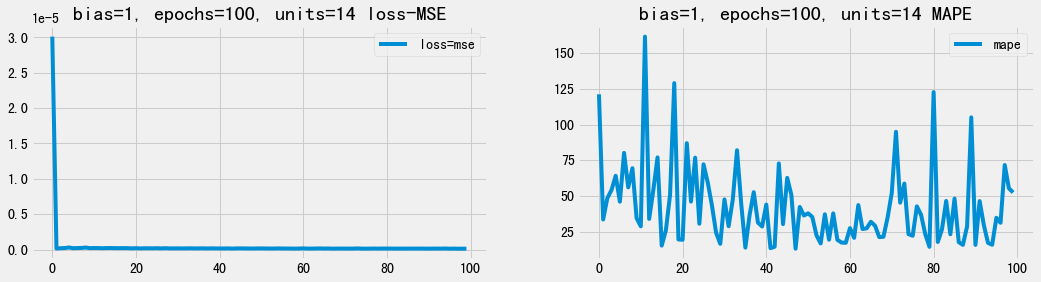

In [53]:
plot_history(historys[0], "bias=1, epochs=100, units=14")

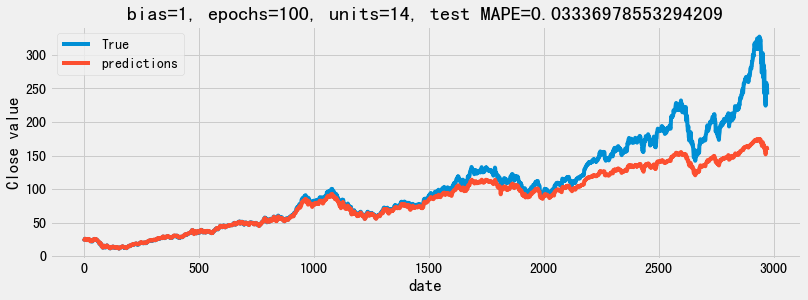

In [54]:
plot_fit(data1_test_y.flatten(), predictions[0].flatten(), f"bias=1, epochs=100, units=14, test MAPE={bias_mapes[0]}")



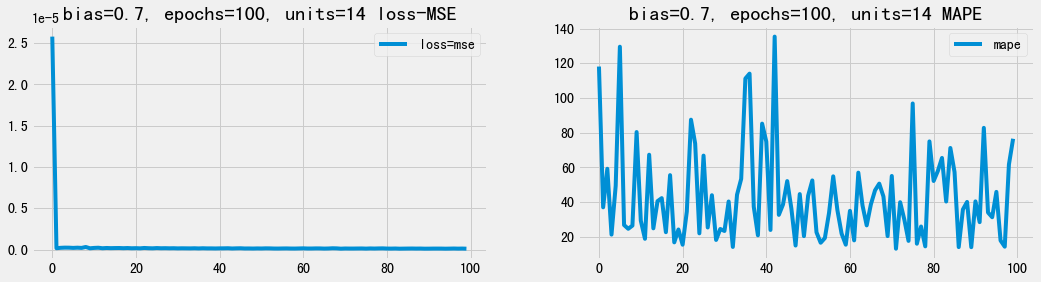

In [55]:
plot_history(historys[1], "bias=0.7, epochs=100, units=14")

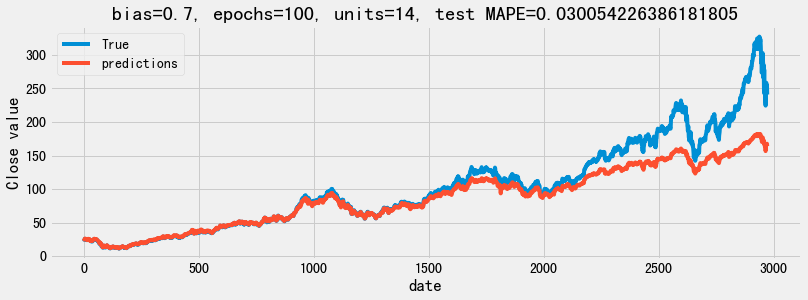

In [56]:
plot_fit(data1_test_y.flatten(), predictions[1].flatten(), f"bias=0.7, epochs=100, units=14, test MAPE={bias_mapes[1]}")



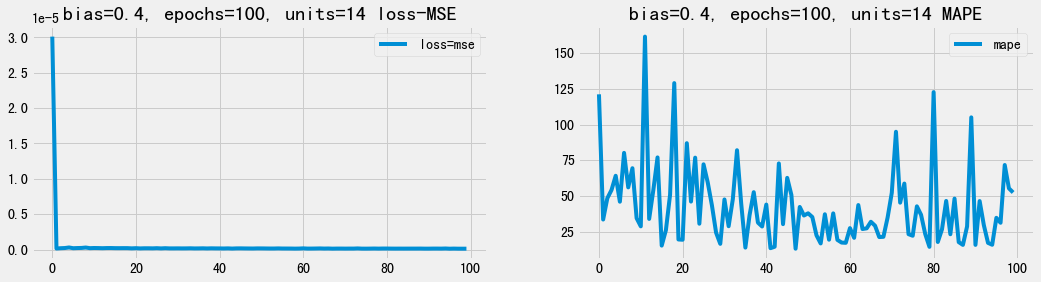

In [57]:
plot_history(historys[0], "bias=0.4, epochs=100, units=14")

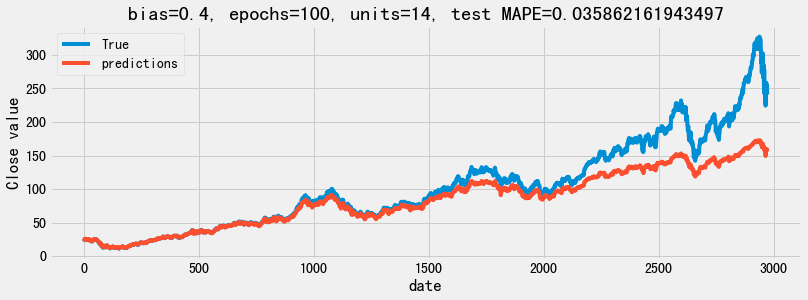

In [58]:
plot_fit(data1_test_y.flatten(), predictions[2].flatten(), f"bias=0.4, epochs=100, units=14, test MAPE={bias_mapes[2]}")